# 농산물 가격 예측을 위한 AI 모델 개발 

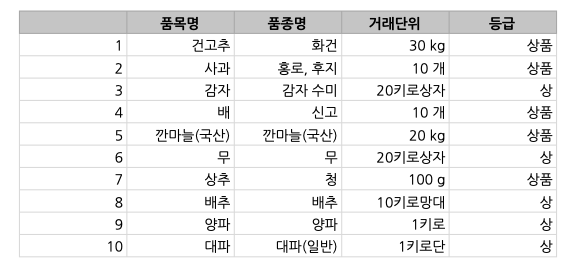

In [129]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Preprocess

In [130]:
train = pd.read_csv("../data/raw_data/train/train.csv")

In [131]:
condition = {
    '건고추' : {
        '품종명' : '화건', '거래단위' : '30 kg', '등급' : '상품'
    },
    '사과' : {
        '품종명' : ['홍로', '후지'], '거래단위' : '10 개', '등급' : '상품'
    },
    '감자' : {
        '품종명' : '감자 수미', '거래단위' : '20키로상자', '등급' : '상'
    },
    '배' : {
        '품종명' : '신고', '거래단위' : '10 개', '등급' : '상품'
    },
    '깐마늘(국산)' : {
        '품종명' : '깐마늘(국산)', '거래단위' : '20 kg', '등급' : '상품'
    },
    '무' : {
        '품종명' : '무', '거래단위' : '20키로상자', '등급' : '상'
    },
    '상추' : {
        '품종명' : '청', '거래단위' : '100 g', '등급' : '상품'
    },
    '배추' : {
        '품종명' : '배추', '거래단위' : '10키로망대', '등급' : '상'
    },
    '양파' : {
        '품종명' : '양파', '거래단위' : '1키로', '등급' : '상'
    },
    '대파' : {
        '품종명' : '대파(일반)', '거래단위' : '1키로단', '등급' : '상'
    }
}

In [132]:
# 시계열 데이터를 위한 시퀀스 생성 함수
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length - 3):
        X.append(data[i:i+seq_length, 0])
        y.append(data[i+seq_length:i+seq_length+3, 0])
    return np.array(X), np.array(y)

In [133]:
seq_length = 9  # T-8 ~ T를 사용

In [134]:
sub = pd.read_csv("../data/raw_data/sample_submission.csv")

In [135]:
for i in tqdm(condition):
    try:
        train_c = train[(train['품목명'] == i ) & (train['품종명'] == condition[i]['품종명']) & (train['거래단위'] == condition[i]['거래단위']) & (train['등급'] == condition[i]['등급'])]
    except:
        train_c = train[(train['품목명'] == i ) & (train['품종명'].isin(condition[i]['품종명'])) & (train['거래단위'] == condition[i]['거래단위']) & (train['등급'] == condition[i]['등급'])]
    train_c = train_c[['평균가격(원)']]

    # MinMaxScaler를 이용한 스케일링
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_c)
    
    X_train, y_train = create_sequences(train_scaled, seq_length)

    # LSTM 모델 생성
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(seq_length, 1)))
    model.add(Dense(3))  # T+1, T+2, T+3 예측
    
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 모델 학습
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # LSTM에 맞게 데이터 형태 변환
    model.fit(X_train, y_train, epochs=20, batch_size=32)

    k = 0

    for j in range(25):
        test = pd.read_csv(f"../data/raw_data/test/TEST_{j:02d}.csv")
        try:
            test = test[(test['품목명'] == i ) & (test['품종명'] == condition[i]['품종명']) & (test['거래단위'] == condition[i]['거래단위']) & (test['등급'] == condition[i]['등급'])]
        except:
            test = test[(test['품목명'] == i ) & (test['품종명'].isin(condition[i]['품종명'])) & (test['거래단위'] == condition[i]['거래단위']) & (test['등급'] == condition[i]['등급'])]
        
        test = test[['평균가격(원)']]
        test_scaled = scaler.fit_transform(test)

        # 테스트 데이터도 시퀀스 형태로 변환
        X_test = np.array([test_scaled.flatten()])  # 테스트 데이터의 마지막 9개 시점을 입력으로 사용
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        # 예측 수행
        predicted = model.predict(X_test)
        
        # 예측값을 원래 스케일로 역변환
        predicted_prices = scaler.inverse_transform(np.concatenate((predicted, np.zeros((predicted.shape[0], 1))), axis=1))[:, :3]
        
        # T+1, T+2, T+3 값을 개별적으로 출력
        T_plus_1 = predicted_prices[0, 0]
        T_plus_2 = predicted_prices[0, 1]
        T_plus_3 = predicted_prices[0, 2]

        sub.loc[k, i] = T_plus_1
        k += 1
        sub.loc[k, i] = T_plus_2
        k += 1
        sub.loc[k, i] = T_plus_3
        k += 1

  0%|                                                                                       | 0/10 [00:00<?, ?it/s]

Epoch 1/20


C:\Users\insu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2186
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1713 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1178 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0742 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0407 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0327 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0328 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0261 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0248 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0296 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

 10%|███████▉                                                                       | 1/10 [00:03<00:32,  3.64s/it]

Epoch 1/20


C:\Users\insu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2293  
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1891 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1192 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0706 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0437 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0298 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0348 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0261 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

 20%|███████████████▊                                                               | 2/10 [00:07<00:28,  3.55s/it]

Epoch 1/20


C:\Users\insu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0379  
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0328 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

 30%|███████████████████████▋                                                       | 3/10 [00:10<00:23,  3.43s/it]

Epoch 1/20


C:\Users\insu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1957  
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1413 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1044 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0527 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0372 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0352 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0279 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0283 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0341 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0303 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0302 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

 40%|███████████████████████████████▌                                               | 4/10 [00:13<00:19,  3.30s/it]

Epoch 1/20


C:\Users\insu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3341  
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2528 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1609 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0945 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0408 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0307 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0300 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0252 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0183 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

 50%|███████████████████████████████████████▌                                       | 5/10 [00:16<00:16,  3.27s/it]

Epoch 1/20


C:\Users\insu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1469  
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1109 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0756 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0605 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0576 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0573 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0538 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0514 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0458 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0466 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0452 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0485 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0474 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0461 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

 60%|███████████████████████████████████████████████▍                               | 6/10 [00:20<00:13,  3.29s/it]

Epoch 1/20


C:\Users\insu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1159  
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0858 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0672 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0501 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0502 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0517 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0479 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0454 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0472 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0417 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0493 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0490 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0385 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0433 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0418 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

 70%|███████████████████████████████████████████████████████▎                       | 7/10 [00:23<00:09,  3.30s/it]

Epoch 1/20


C:\Users\insu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0956  
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0711 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0485 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0366 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0360 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0334 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0377 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0305 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0324 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0326 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

 80%|███████████████████████████████████████████████████████████████▏               | 8/10 [00:26<00:06,  3.20s/it]

Epoch 1/20


C:\Users\insu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1360  
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1090 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0837 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0470 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0360 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0326 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0380 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0307 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0285 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0294 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0320 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0287 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [00:29<00:03,  3.13s/it]

Epoch 1/20


C:\Users\insu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0963  
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0860 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0557 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0417 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0336 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0318 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0294 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0296 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0315 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0279 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0234 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.25s/it]


In [ ]:
sub.to_csv("../data/submission/sub_01.csv", index=False)